# Building Multimodal Model

In [1]:
cd ..

/notebooks/MultimodalTweetsClassification


In [2]:
#ensuring that any edits to libraries you make are reloaded here automatically
#to ensuere charts or images displayed are shown in this notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

In [3]:
#importing required modules
from exp.Required_Modules_And_Packages import *
from exp.Data_Reading_And_Preprocessing import *
from exp.Required_Integration_Functionalities_For_Transformer_To_Fastai import *
from exp.Required_Functionalities_To_Handal_Multimodal_Dataset import *
from exp.Multimodal_Model_With_Intermediate_Or_EmbraceNet_Fusion import *

In [4]:
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig

In [5]:
path = Path('/notebooks/MultimodalTweetsClassification')
# path.ls()

In [6]:
path_img = path/'data_image'

In [7]:
# Uncomment the code if dataset and labels are in .tar.gz and .zip format respectively

# data = "CrisisMMD_v2.tar.gz"
# agreed_label = "crisismmd_datasplit_agreed_label.zip"
# untar_data_and_unzip_label(data,agreed_label)

In [8]:
#reading csv files and doing initial necessary processing
data_info_text_image,test_data_info_text_image = get_dataframe(*get_tsv_data_files('Informativeness_task_tsv_files'),path)

reading data and preprocessing it.....
done!!


In [9]:
print(f"shape of data: {data_info_text_image.shape}\n")
print(f"train set: {data_info_text_image['is_valid'].value_counts()[0]}")
print(f"valid set: {data_info_text_image['is_valid'].value_counts()[1]}")      
print("="*50)
print(f"shape of test data: {test_data_info_text_image.shape}\n")

shape of data: (11173, 10)

train set: 9600
valid set: 1573
shape of test data: (1534, 9)



In [10]:
MODEL_CLASSES = {'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig)}

In [11]:
model_type = 'xlm'
pretrained_model_name = 'xlm-clm-enfr-1024'

In [12]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [13]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [14]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)

In [15]:
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)
tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

In [16]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [17]:
# preprocessing and creating text databunch object for data(train and dev split) and test data(test split)
data_clas = get_text_data(data_info_text_image,path,pad_first,pad_idx,processor=transformer_processor)
test_data_clas = get_test_text_data(test_data_info_text_image,path,pad_first,pad_idx,processor=transformer_processor)

# making single databunch object of data and test data
data_clas.add_test(test_data_clas.train_ds)
data_clas.test_ds.y = test_data_clas.train_ds.y

In [18]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 2
config.use_bfloat16 = False
# print(config)

In [19]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
custom_transformer_model = CustomTransformerModel(pad_idx,transformer_model = transformer_model)

In [20]:
CustomAdamW = partial(AdamW, correct_bias=False)

learn_clas = Learner(data_clas, custom_transformer_model,loss_func=nn.CrossEntropyLoss(),opt_func = CustomAdamW, 
                  metrics=[accuracy,Precision1(average='macro'),
                Precision1(average='weighted'),Recall(average='macro'),Recall(average='weighted'),
               FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)])

In [21]:
# print(learn_clas.model)

In [22]:
learn_clas.model.transformer=learn_clas.model.transformer.transformer

In [23]:
# print(learn_clas.model)

In [24]:
#creating image databunch object for data(train and dev split) and test data(test split)
data_img = get_image_data(data_info_text_image,path,224)
test_data_img = get_test_image_data(test_data_info_text_image,path,224)

# making single databunch object of data and test data
data_img.add_test(test_data_img.x)
data_img.test_ds.y = test_data_img.y

In [25]:
# creating a learner object with image model to use it for concatenation 
arch = models.densenet161
learn_img = cnn_learner(data_img, arch, metrics=[accuracy,Precision(average='macro'),Precision(average='weighted'),
                                                 Recall(average='macro'),Recall(average='weighted'),
                                                 FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)])

In [26]:
# learn_img.model

In [27]:
learn_img.model[-1] = learn_img.model[-1][:-3]
# learn_img.model

In [28]:
#creating dataset object of ConcatDataset Class
train_ds = ConcatDataset(data_img.train_ds, data_clas.train_ds.x, data_clas.train_ds.y)
valid_ds = ConcatDataset(data_img.valid_ds, data_clas.valid_ds.x, data_clas.valid_ds.y)
test_ds = ConcatDataset(data_img.test_ds, data_clas.test_ds.x,data_clas.test_ds.y)

# creating data sampler object
bs = 16
train_sampler = SortishSampler(data_clas.train_ds.x, key=lambda t: len(data_clas.train_ds[t][0].data), bs=bs//2)
valid_sampler = SortSampler(data_clas.valid_ds.x, key=lambda t: len(data_clas.valid_ds[t][0].data))
test_sampler = SortSampler(data_clas.test_ds.x, key=lambda t: len(data_clas.test_ds[t][0].data))

In [29]:
# creating dataloader object for databuch
train_dl = DataLoader(train_ds, bs, sampler=train_sampler)
valid_dl = DataLoader(valid_ds, bs, sampler=valid_sampler)
test_dl = DataLoader(test_ds, bs, sampler=test_sampler)

In [30]:
#creating combined image+text databuch object to use it in learner for training 
data = DataBunch(train_dl=train_dl,valid_dl=valid_dl,test_dl=test_dl, device=defaults.device, 
                 collate_fn=my_collate, path=path)

In [31]:
(x1,x2),y = next(iter(data.test_dl))
print(f'Shape image batch : {(x1.shape)}')
print(f'Shape text batch: {x2.shape}')
print(f'Shape dependent var: {y.shape}')

Shape image batch : torch.Size([16, 3, 224, 224])
Shape text batch: torch.Size([16, 130])
Shape dependent var: torch.Size([16])


In [32]:
lin_layers = [512+1024, 2]
embrace_layer_size=256
ps = 0.1
model = EmbraceNetConcatModel(learn_img.model, learn_clas.model, lin_layers, ps,embrace_layer_size,with_transformer=True)

In [33]:
#making layer groupes and creating learner object for training
loss_func = nn.CrossEntropyLoss()

layer_groups = [nn.Sequential(*(flatten_model(learn_clas.model.transformer.position_embeddings)+
                                flatten_model(learn_clas.model.transformer.lang_embeddings)+
                                flatten_model(learn_clas.model.transformer.embeddings)+
                                flatten_model(learn_clas.model.transformer.layer_norm_emb)+
                                flatten_model(learn_img.layer_groups[0]))),
                
                nn.Sequential(*(flatten_model(learn_clas.model.transformer.attentions)+
                                flatten_model(learn_img.layer_groups[1]))),
                
                nn.Sequential(*(flatten_model(learn_clas.model.transformer.layer_norm1)+
                                flatten_model(learn_img.layer_groups[2]))),
               nn.Sequential(*(flatten_model(learn_clas.model.transformer.ffns)+
                               flatten_model(learn_clas.model.transformer.layer_norm2)+
                   flatten_model(model.layers)))]

In [34]:
# model.eval()
learn = Learner(data, model, loss_func=loss_func, metrics=[accuracy,Precision1(average='macro'),
                Precision1(average='weighted'),Recall(average='macro'),Recall(average='weighted'),
               FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)],
            callback_fns=[ShowGraph,partial(EarlyStoppingCallback, monitor='valid_loss', min_delta=0.01, patience=3),
               partial(ReduceLROnPlateauCallback,monitor='valid_loss', mode='auto', patience=0,
                       factor=0.2, min_delta=0, min_lr=0.000001)],layer_groups=layer_groups)

In [35]:
len(learn.layer_groups)

4

In [39]:
learn.freeze()

In [41]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.98E-02
Min loss divided by 10: 5.75E-03


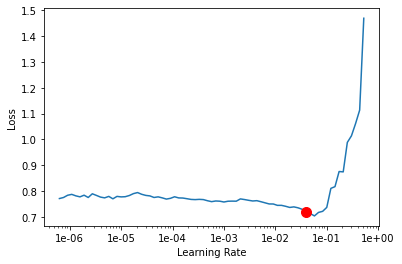

In [42]:
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,0.565395,0.535220,0.761602,0.731675,0.767924,0.741487,0.761602,0.735750,0.764072,13:52
1,0.484240,0.470728,0.779402,0.761468,0.773185,0.714761,0.779402,0.728335,0.768695,13:22
2,0.467717,0.415562,0.804832,0.790130,0.800488,0.750977,0.804832,0.764345,0.797815,13:23
3,0.450078,0.391478,0.818182,0.796344,0.815609,0.785108,0.818182,0.790140,0.816426,13:23
4,0.397674,0.376292,0.821996,0.808043,0.818503,0.776102,0.821996,0.788116,0.817149,13:21


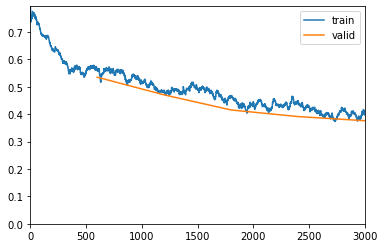

Better model found at epoch 0 with accuracy value: 0.7616020441055298.
Better model found at epoch 1 with accuracy value: 0.7794024348258972.
Better model found at epoch 2 with accuracy value: 0.8048315048217773.
Better model found at epoch 3 with accuracy value: 0.8181818127632141.
Better model found at epoch 4 with accuracy value: 0.8219962120056152.


In [43]:
# training the model's top layer's keeping keep other layer's in freezing mode, all the metrics shown here, have been
# evaluted on validation set
learn.fit_one_cycle(5,slice(1e-2), moms=(0.8, 0.7),wd=1e-1,
                   callbacks=[SaveModelCallback(learn,every='improvement', monitor='accuracy', name='best')])

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,0.406335,0.390267,0.815639,0.821143,0.817798,0.748167,0.815639,0.767966,0.804005,13:24
1,0.344056,0.364454,0.827082,0.803690,0.827798,0.806053,0.827082,0.804843,0.827417,13:24


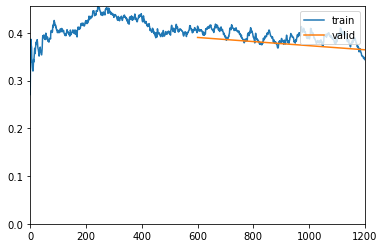

In [44]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, slice(5e-3/(2.6**4), 5e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,0.447752,0.406306,0.809282,0.810500,0.809753,0.741951,0.809282,0.760657,0.797623,14:53
1,0.418440,0.373185,0.835346,0.818953,0.832568,0.799867,0.835346,0.807962,0.832811,14:51
2,0.350543,0.340674,0.843611,0.826541,0.841501,0.813427,0.843611,0.819297,0.842010,14:53


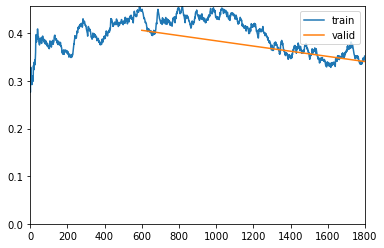

In [45]:
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(2e-3/(2.6**4), 2e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


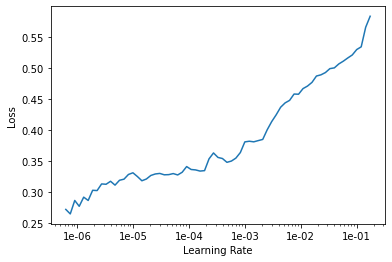

In [46]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,0.327984,0.347630,0.840432,0.823161,0.838152,0.809085,0.840432,0.815325,0.838657,16:35
1,0.297841,0.351281,0.839797,0.826718,0.837100,0.801207,0.839797,0.811549,0.836550,16:27


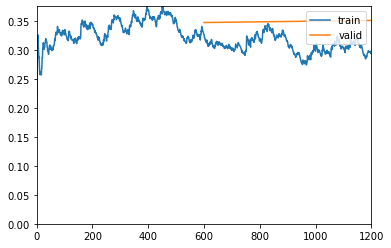

In [47]:
learn.fit_one_cycle(2, slice(5e-4/(2.6**4), 5e-4), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,0.308873,0.387475,0.839797,0.831843,0.837707,0.794790,0.839797,0.808606,0.835081,16:22
1,0.293808,0.363477,0.841068,0.833019,0.838987,0.796724,0.841068,0.810358,0.836508,16:25
2,0.247943,0.390583,0.839161,0.825429,0.836427,0.801227,0.839161,0.811129,0.836062,16:25
3,0.220502,0.385064,0.840432,0.822431,0.838363,0.810566,0.840432,0.815921,0.838938,16:56


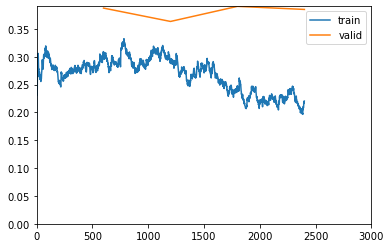

Better model found at epoch 0 with accuracy value: 0.8397965431213379.
Better model found at epoch 1 with accuracy value: 0.8410680294036865.
Epoch 2: reducing lr to 6.11262021936289e-05
Epoch 3: reducing lr to 1.8825834605023693e-05


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [48]:
# training all layer's of the model and saving the best one 
learn.fit_one_cycle(5, slice(5e-4/(2.6**4), 5e-4), moms=(0.8, 0.7), wd=1e-1,
                    callbacks=[SaveModelCallback(learn,every='improvement', monitor='accuracy', name='best')])

In [49]:
interp = ClassificationInterpretation.from_learner(learn)

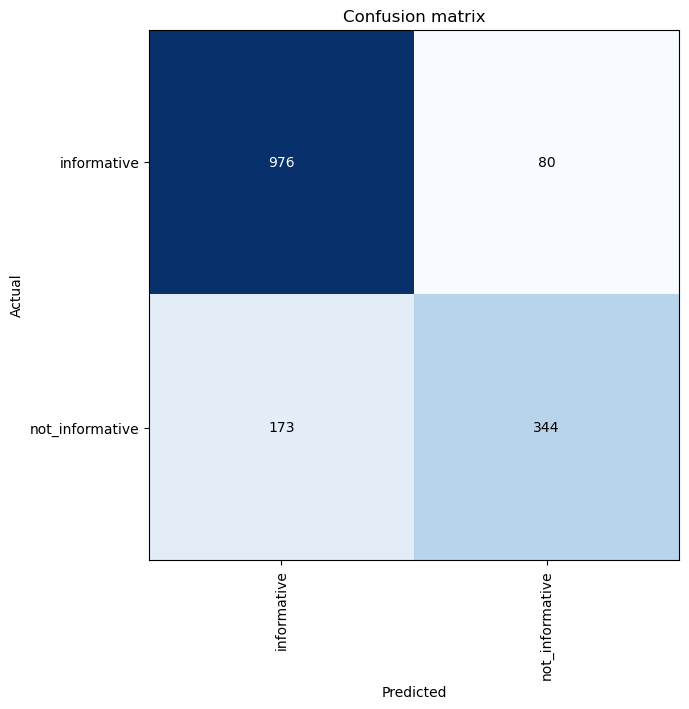

In [50]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=100)

In [51]:
learn.validate(data.valid_dl,metrics=[accuracy,Precision1(average='macro'),Precision1(average='weighted'),
                                                 Recall(average='macro'),Recall(average='weighted'),
                                                 FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)])

[0.36171928,
 tensor(0.8373),
 tensor(0.8273),
 tensor(0.8348),
 tensor(0.7934),
 tensor(0.8373),
 tensor(0.8063),
 tensor(0.8328)]

In [52]:
#making on validation set to use it for classification report
valid_preds,valid_y,losses = learn.get_preds(ds_type=DatasetType.Valid,with_loss=True)
valid_y_preds = valid_preds.argmax(1)

target_names = ['informative','not_informative']

print(classification_report(valid_y, valid_y_preds, target_names=target_names))

                 precision    recall  f1-score   support

    informative       0.85      0.93      0.89      1056
not_informative       0.82      0.67      0.74       517

       accuracy                           0.84      1573
      macro avg       0.84      0.80      0.81      1573
   weighted avg       0.84      0.84      0.84      1573



In [53]:
learn.validate(data.test_dl,metrics=[accuracy,Precision1(average='macro'),Precision1(average='weighted'),
                                                 Recall(average='macro'),Recall(average='weighted'),
                                                 FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)])

[0.35727713,
 tensor(0.8449),
 tensor(0.8321),
 tensor(0.8424),
 tensor(0.8080),
 tensor(0.8449),
 tensor(0.8179),
 tensor(0.8419)]

In [54]:
#making on test set to use it for classification report
test_preds,test_y,losses = learn.get_preds(ds_type=DatasetType.Test,with_loss=True)
test_y_preds = test_preds.argmax(1)

target_names = ['informative','not_informative']
print(classification_report(test_y, test_y_preds, target_names=target_names))

                 precision    recall  f1-score   support

    informative       0.87      0.92      0.89      1030
not_informative       0.81      0.71      0.76       504

       accuracy                           0.85      1534
      macro avg       0.84      0.81      0.82      1534
   weighted avg       0.85      0.85      0.85      1534

